In [1]:
import numpy as np
import pickle
import time
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime

In [2]:
start_run = 200
end_run = 200

output_file_name = 'Run200_list.pkl'
geometry = 'Prototype_Geometry_5-3-24.txt'
boards = 3
window = 1

In [3]:
Tstamp_us = []
Brd = []
Ch = []
LG = []
HG = []


file_start_time = None

for run_number in range(start_run, end_run+1):
    input_file_name = f"Run{run_number}_list.txt"
    RunTstamp_us = []
    RunBrd = []
    RunCh = []
    RunLG = []
    RunHG = []

    with open(input_file_name) as f:
        lines = f.read().split('\n')

    last_tstamp = 0  # Initialize last timestamp for continuity across files

    for i, line in enumerate(lines):
        if i == 6:  # Line containing the start time
            start_time_str = ' '.join(line.split()[4:-1])  # Extract start time string, excluding "UTC"
            file_start_time = datetime.strptime(start_time_str, "%a %b %d %H:%M:%S %Y")
            file_start_time = file_start_time.timestamp() * 1e6  # Convert to microseconds
            #file_start_time = 0
        elif i > 8:
            data = line.split()

            if len(data) == 6:
                RunTstamp_us.append(float(data[0]) + file_start_time)
                last_tstamp = float(data[0]) + file_start_time
                RunBrd.append(int(data[2]))
                RunCh.append(int(data[3]))
                RunLG.append(int(data[4]))
                RunHG.append(int(data[5]))
    
            elif len(data) == 4:
                if last_tstamp is not None:
                    RunTstamp_us.append(last_tstamp)
                RunBrd.append(int(data[0]))
                RunCh.append(int(data[1]))
                RunLG.append(int(data[2]))
                RunHG.append(int(data[3]))
    
    Tstamp_us.extend(RunTstamp_us)
    Brd.extend(RunBrd)
    Ch.extend(RunCh)
    LG.extend(RunLG)
    HG.extend(RunHG)

Tstamp_us = np.array(Tstamp_us)
Brd = np.array(Brd)
Ch = np.array(Ch)
LG = np.array(LG)
HG = np.array(HG)

34556


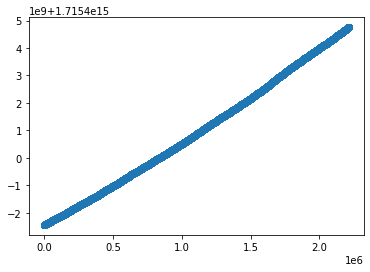

In [4]:
print(len(list(set(Tstamp_us))))

plt.scatter(range(len(Tstamp_us)), Tstamp_us)

In [5]:
# Find unique values and their indices
unique_values, unique_indices = np.unique(Tstamp_us, return_index=True)

# Sort the unique indices to maintain the order
sorted_unique_indices = np.sort(unique_indices)

# Get the unique values in the original order
tstamps = Tstamp_us[sorted_unique_indices]
brds = Brd[sorted_unique_indices]

brd0 = []
brd1 = []
brd2 = []

brdnum = 0

b0 = 0
b1 = 0
b2 = 0
b0n = 0
b1n = 0
b2n = 0

# First, find potential full events to record average time delays
for i in range(len(tstamps)):
    if brdnum == 0:
        b0  = tstamps[i]
        brdnum = 1
        b0n = brds[i]
    elif (brdnum == 1) & (abs(tstamps[i]-b0) < 50000):
        b1 = tstamps[i]
        b1n = brds[i]
        brdnum = 2
    elif (brdnum == 2) & (abs(tstamps[i]-b0) < 50000):
        b2 = tstamps[i]
        b2n = brds[i]
        
        if (b0n != b1n) & (b0n != b2n) & (b1n != b2n):
            brd0.append(b0)
            brd1.append(b1)
            brd2.append(b2)
        brdnum = 0
    else:
        brdnum = 0
        print("Skip")
        
        
diff1array = np.array(brd1) - np.array(brd0)
diff2array = np.array(brd2) - np.array(brd0)

diff1 = np.mean(diff1array)
diff2 = np.mean(diff2array)

diff1array = diff1array[abs(diff1array - diff1) < 1000]
diff2array = diff2array[abs(diff2array - diff2) < 1000]
diff1 = np.mean(diff1array)
diff2 = np.mean(diff2array)


Text(0.5, 0, 'Time Stamp Entry #')

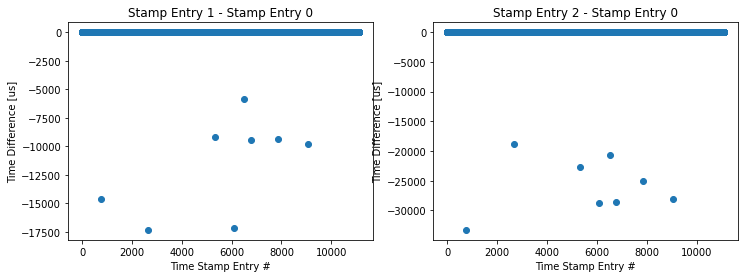

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].scatter(range(len(brd1)), (np.array(brd1) - np.array(brd0))-diff1)
axs[0].set_title("Stamp Entry 1 - Stamp Entry 0")
axs[0].set_ylabel("Time Difference [us]")
axs[0].set_xlabel("Time Stamp Entry #")

axs[1].scatter(range(len(brd1)), (np.array(brd2) - np.array(brd0))-diff2)
axs[1].set_title("Stamp Entry 2 - Stamp Entry 0")
axs[1].set_ylabel("Time Difference [us]")
axs[1].set_xlabel("Time Stamp Entry #")


In [7]:
brdnum = 0
b0 = 0
b1 = 0
b2 = 0
b0n = 0
b1n = 0
b2n = 0
evt = 0
evtIDs = np.zeros_like(Tstamp_us)
evtIDs.fill(-1)

# Now that the average time delays between boards are known, use this to identify events
for i in range(len(tstamps)):
    if brdnum == 0:
        b0  = tstamps[i]
        brdnum = 1
        b0n = brds[i]
    elif (brdnum == 1) & (abs((diff1-(abs(tstamps[i]-b0)))) < window):
        b1 = tstamps[i]
        b1n = brds[i]
        brdnum = 2
    elif (brdnum == 2) & (abs((diff2-(abs(tstamps[i]-b0)))) < window):
        b2 = tstamps[i]
        b2n = brds[i]
        if (b0n != b1n) & (b0n != b2n) & (b1n != b2n):            
            mask = (Tstamp_us == b0) | (Tstamp_us == b1) | (Tstamp_us == b2)
            evtIDs[mask] = evt
            
            mask = (Tstamp_us == b1)
            Tstamp_us[mask] = Tstamp_us[mask] - diff1
            mask = (Tstamp_us == b2)
            Tstamp_us[mask] = Tstamp_us[mask] - diff2
            
            evt = evt+1         
        brdnum = 0
    else:
        brdnum = 0
        
mask = (evtIDs != -1)
evtIDs = evtIDs[mask]
Brd = Brd[mask]
Ch = Ch[mask]
LG = LG[mask]
HG = HG[mask]
Tstamp_us = Tstamp_us[mask]

In [11]:
# Define empty lists for x, y, and z positions
x_pos = []
y_pos = []
z_pos = []

# Read coordinates from the text file
with open(geometry, "r") as file:
    coordinates = [eval(line.strip()) for line in file]

# Calculate positions based on Ch and Brd values
for i in range(len(Ch)):
    total_channel = Ch[i] + (Brd[i] * 64)
    if total_channel < len(coordinates):
        x, y, z = coordinates[total_channel]
        x_pos.append(x)
        y_pos.append(y)
        z_pos.append(z)
    else:
        print(f"Error: total_channel value {total_channel} is out of range.")

In [12]:
events = pd.DataFrame({
    'Brd': Brd,
    'Ch': Ch,
    'LG': LG,
    'HG': HG,
    'Tstamp_us': Tstamp_us,
    'event_ids': evtIDs.astype(int),
    'x_pos': x_pos,
    'y_pos': y_pos,
    'z_pos': z_pos,
})

In [13]:
with open(output_file_name, 'wb') as handle:
    pickle.dump(events, handle, protocol=pickle.HIGHEST_PROTOCOL)
    